In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import argparse
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import squeeznet as model
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import embed

In [2]:
batch_size = 4
epoch = 2
learning_rate = 0.001
momentum = 0.9
no_cuda = True #True calcul with GPU, False with cpu
log_schedule = 10
model_name =None
want_to_test = False
epoch_55 =False
num_classes =9
num_workers = 4

In [3]:
data_transform = transforms.Compose([
        transforms.CenterCrop([256,256]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [4]:
transformed_eyes = datasets.ImageFolder(root='data/train',
                                           transform=data_transform)

In [5]:
dataset_loader = torch.utils.data.DataLoader(transformed_eyes,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=num_workers)

In [6]:
len(dataset_loader)

155

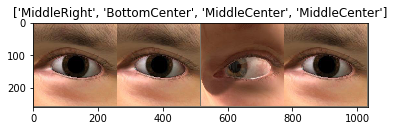

In [7]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataset_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[transformed_eyes.classes[x] for x in classes])

In [8]:
transformed_eyes2 = datasets.ImageFolder(root='data/test',
                                           transform=data_transform)

In [9]:
test_loader = torch.utils.data.DataLoader(transformed_eyes2,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=num_workers)

In [10]:
net  = model.SqueezeNet()
if model_name is not None:
    print("loading pre trained weights")
    pretrained_weights = torch.load(model_name)
    net.load_state_dict(pretrained_weights)

if no_cuda:
    net.cuda()

In [11]:
def paramsforepoch(epoch):
    p = dict()
    regimes = [[1, 18, 5e-3, 5e-4],
               [19, 29, 1e-3, 5e-4],
               [30, 43, 5e-4, 5e-4],
               [44, 52, 1e-4, 0],
               [53, 1e8, 1e-5, 0]]
    # regimes = [[1, 18, 1e-4, 5e-4],
    #            [19, 29, 5e-5, 5e-4],
    #            [30, 43, 1e-5, 5e-4],
    #            [44, 52, 5e-6, 0],
    #            [53, 1e8, 1e-6, 0]]
    for i, row in enumerate(regimes):
        if epoch >= row[0] and epoch <= row[1]:
            p['learning_rate'] = row[2]
            p['weight_decay'] = row[3]
    return p

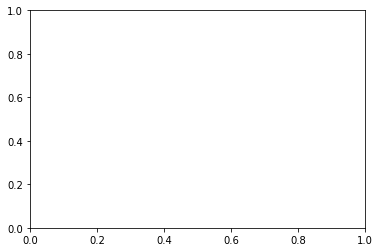

In [12]:
avg_loss = list()
best_accuracy = 0.0
fig1, ax1 = plt.subplots()

In [13]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=5e-4)

In [14]:
def adjustlrwd(params):
    for param_group in optimizer.state_dict()['param_groups']:
        param_group['lr'] = params['learning_rate']
        param_group['weight_decay'] = params['weight_decay']

In [15]:
def train(epoch):

    # set the optimizer for this epoch
    if epoch_55:
        params = paramsforepoch(epoch)
        print("Configuring optimizer with lr={:.5f} and weight_decay={:.4f}".format(params['learning_rate'], params['weight_decay']))
        adjustlrwd(params)
    ###########################################################################

    global avg_loss
    correct = -1
    net.train()
    for b_idx, (data, classes) in enumerate(dataset_loader):
        # trying to overfit a small data
        # if b_idx == 100:
        #     break

        if no_cuda:
            data, classes = data.cuda(), classes.cuda()
        # convert the data and targets into Variable and cuda form
        data, classes = Variable(data), Variable(classes)

        # train the network
        optimizer.zero_grad()
        scores = net.forward(data)
        print(scores.shape)
        scores = scores.view(data.size()[0], num_classes)
        loss = F.nll_loss(scores, classes)
        # compute the accuracy
        pred = scores.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(classes.data).cpu().sum()

        avg_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        if b_idx % log_schedule == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (b_idx+1) * len(data), len(dataset_loader.dataset),
                100. * (b_idx+1)*len(data) / len(dataset_loader.dataset), loss.item()))

            # also plot the loss, it should go down exponentially at some point
            ax1.plot(avg_loss)
            fig1.savefig("Squeezenet_loss.jpg")

    # now that the epoch is completed plot the accuracy
    train_accuracy = correct / float(len(dataset_loader.dataset))
    print("training accuracy ({:.2f}%)".format(100*train_accuracy))
    return (train_accuracy*100.0)

In [16]:
def val():
    global best_accuracy
    correct = -1
    net.eval()
    for idx, (data, classes) in enumerate(test_loader):
        if idx == 73:
            break

        if no_cuda:
            data, classes = data.cuda(), classes.cuda()
        data, classes = Variable(data), Variable(classes)

        # do the forward pass
        score = net.forward(data)
        pred = score.data.max(1)[1] # got the indices of the maximum, match them
        correct += pred.eq(classes.data).cpu().sum()

    print("predicted {} out of {}".format(correct, 73*64))
    val_accuracy = correct / (73.0*64.0) * 100
    print("accuracy = {:.2f}".format(val_accuracy))

    # now save the model if it has better accuracy than the best model seen so forward
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        # save the model
    torch.save(net.state_dict(),'bsqueezenet_onfulldata.pth')
    return val_accuracy


In [17]:
def test():
    # load the best saved model
    weights = torch.load('bsqueezenet_onfulldatatest2.pth')
    net.load_state_dict(weights)
    net.eval()

    test_correct = 0
    total_examples = 0
    accuracy = 0.0
    for idx, (data, classes) in enumerate(test_loader):
        total_examples += len(classes)
        data, classes = Variable(data), Variable(classes)
        if no_cuda:
            data, classes = data.cuda(), classes.cuda()

        scores = net(data)
        pred = scores.data.max(1)[1]
        test_correct += pred.eq(classes.data).cpu().sum()
    print("Predicted {} out of {} correctly".format(test_correct, total_examples))
    return 100.0 * test_correct / (float(total_examples))

In [18]:
def main():
    if not want_to_test:
        fig2, ax2 = plt.subplots()
        train_acc, val_acc = list(), list()
        for i in range(1,epoch+1):
            train_acc.append(train(i))
            val_acc.append(val())
            ax2.plot(train_acc, 'g')
            ax2.plot(val_acc, 'b')
            fig2.savefig('train_val_accuracy.jpg')
    else:
        test_acc = test()
        print("Testing accuracy on CIFAR-10 data is {:.2f}%".format(test_acc))


torch.Size([4, 9, 1, 1])
Train Epoch: 1 [4/255 (2%)]	Loss: 1.795815
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
Train Epoch: 1 [44/255 (17%)]	Loss: 2.319541
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
Train Epoch: 1 [84/255 (33%)]	Loss: 2.409886
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 1])
Train Epoch: 1 [124/255 (49%)]	Loss: 2.362289
torch.Size([4, 9, 1, 1])
torch.Size([4, 9, 1, 

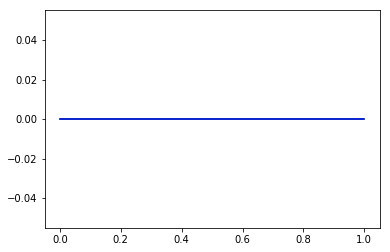

In [18]:
main()

def WantToTest():
    #load data
    data_transform = transforms.Compose([
        transforms.CenterCrop([256,256]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    transformed_eyes = datasets.ImageFolder(root='data/toClassify',
                                           transform=data_transform)
    dataset_loader = torch.utils.data.DataLoader(transformed_eyes,
                                             batch_size=1, shuffle=True,
                                             num_workers=num_workers)
    #load the model
    net  = model.SqueezeNet()
    weights = torch.load('bsqueezenet_onfulldata.pth')
    net.load_state_dict(weights)
    net.eval()
    #make prediction
    for idx,data in enumerate(dataset_loader):
        data = Variable(data)
        scores = net.forward(data)
        scores.view(data.size()[0], num_classes)
        print(scores)
    #show result
    

def predict_image(image_path):
    print("prediciton in progress")
    image = Image.open(image_path)

    data_transform = transforms.Compose([
        transforms.CenterCrop([256,256]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image_tensor = data_transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    
    input = Variable(image_tensor)
    output = net.forward(input)
    print(output)
    index = output.data.numpy().argmax()
    return index

In [20]:
import os
import pandas as pd
from PIL import Image

#loading model 
net  = model.SqueezeNet()
weights = torch.load('bsqueezenet_onfulldatatest.pth')
net.load_state_dict(weights)
net.eval()
#loading classes    
target = ['BottomCenter','BottomLeft','BottomRight','MiddleCenter','MiddleLeft','MiddleRight','TopCenter','TopLeft', 'TopRight']
#creating var that will contain the result
df = pd.DataFrame(columns=["file", "prediction"])
for file in os.listdir('data/toClassify'):
    if file.endswith(".jpg"):
        image = Image.open("data/toClassify/" + str(file))
        data_transform = transforms.Compose([
        transforms.CenterCrop([256,256]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
        image_tensor = data_transform(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
    
        input = Variable(image_tensor)
        output = net.forward(input)
        
        result = target[output.data.numpy().argmax()]
        df = df.append({"file": file,"prediction":  result}, ignore_index=True)
df.to_csv("result.csv",header=True,index=None,sep=",")

In [37]:
for i in (weights):
    print(i)
    a = weights[i]
    print(a)

conv1.weight
tensor([[[[-2.1044e-03, -1.3924e-04, -1.2128e-03,  ...,  3.4693e-03,
            9.0823e-04, -3.2488e-03],
          [-2.8098e-03,  6.7999e-04,  2.1067e-04,  ..., -2.2881e-03,
            6.9709e-03, -1.1960e-03],
          [ 6.3829e-04,  1.7353e-03, -3.2946e-03,  ...,  1.7292e-03,
            3.4780e-03, -3.8179e-03],
          ...,
          [ 3.2828e-03,  2.4657e-03, -4.8788e-03,  ..., -7.2559e-04,
           -1.2487e-03, -1.4789e-03],
          [-5.2008e-03,  2.3895e-03,  1.0767e-02,  ...,  8.3751e-04,
           -6.5412e-06, -1.7158e-03],
          [ 4.4495e-03, -1.6725e-03, -1.4288e-03,  ...,  1.0474e-03,
            2.1984e-03, -9.5449e-03]],

         [[-5.8639e-04,  8.5553e-03, -1.9224e-03,  ...,  2.2637e-03,
            3.9094e-03, -2.8833e-03],
          [-2.0494e-03, -2.1920e-03,  4.0067e-03,  ..., -6.9518e-03,
            5.9959e-04,  6.1156e-04],
          [ 5.0383e-04,  2.9181e-04, -1.3479e-03,  ...,  3.9897e-05,
           -2.0024e-03, -2.6835e-03],
       

            4.8600e-03, -1.8196e-03]]]])
conv1.bias
tensor(1.00000e-03 *
       [-0.8035,  2.0706,  2.7894,  2.6510,  0.3437,  1.7300,  0.7670,
         0.0339,  1.6874, -1.1329, -1.8540,  1.2597,  0.1401,  2.1425,
         0.1672,  0.7636, -1.0971, -1.4409,  2.0564,  2.1053, -1.9829,
         1.6353, -1.0479, -1.1260,  1.5770, -1.0345,  1.0445,  0.1082,
         1.1120, -2.3160,  1.9052, -2.2547,  0.6695,  0.9183,  2.0009,
        -0.1928,  2.1596,  2.8292, -0.1747, -2.8039, -1.8867,  1.7814,
         1.2413, -1.1219, -2.0167, -0.3622,  2.5024, -1.1139,  0.5448,
         0.1677, -2.6286,  0.9477, -0.0466,  0.8382,  0.3842,  2.1370,
         1.8855, -2.0934, -0.0601,  1.7182,  0.3302, -2.2967,  1.5355,
        -0.6966,  1.9815,  0.5022,  0.0730, -0.5278, -0.1333,  1.7778,
        -1.6028, -1.3449, -0.4325,  2.8813, -2.6894, -2.0481, -1.2717,
        -0.8638,  1.8253, -0.0907, -1.5120,  0.3883,  1.5303,  2.5428,
        -2.4389, -2.2062,  2.4881,  2.0539,  1.8610, -1.9136,  1.7845,
    

         [[ 0.1145]]]])
fire2.conv2.bias
tensor([ 0.0072,  0.0218,  0.0376,  0.0401,  0.0620, -0.1970,  0.1392,
         0.1869,  0.2150, -0.0411, -0.1371,  0.0504,  0.1431,  0.1846,
        -0.2414, -0.0044,  0.0429,  0.0608, -0.0216, -0.2111,  0.2497,
         0.0151,  0.1309, -0.0625,  0.2492,  0.2325, -0.1941,  0.2220,
         0.1655, -0.1563,  0.2480, -0.1947, -0.1559,  0.1263, -0.2092,
        -0.1866, -0.0867, -0.1403, -0.0474, -0.0869,  0.0258, -0.0807,
         0.1370, -0.2360,  0.1105, -0.0018, -0.2206, -0.1365, -0.1876,
        -0.0388, -0.2113, -0.1208, -0.0325,  0.1233, -0.0913,  0.0962,
        -0.1248, -0.2491,  0.1188, -0.1273, -0.1677,  0.0427,  0.1544,
        -0.0277])
fire2.bn2.weight
tensor([ 1.0091,  1.0053,  0.9997,  1.0056,  1.0018,  0.9883,  0.9950,
         0.9961,  0.9994,  1.0122,  0.9976,  0.9967,  0.9992,  0.9984,
         0.9966,  0.9928,  0.9821,  0.9989,  0.9939,  0.9990,  0.9995,
         1.0017,  0.9937,  1.0058,  0.9959,  1.0038,  0.9958,  1.0021,
 

          [ 1.1493e-01,  1.6137e-01, -9.4281e-02]]]])
fire2.conv3.bias
tensor(1.00000e-02 *
       [ 1.0870, -2.8112,  7.9898, -4.2594, -0.2644, -5.9626,  5.4727,
         5.6929,  7.9699,  3.1503, -5.3258,  0.2461,  1.3048, -4.1578,
         7.9354,  7.4407,  5.8509, -1.1289, -4.5162,  3.2006,  7.1649,
         7.6860,  0.4045, -3.1235, -1.1556, -2.1225,  5.6578, -1.1704,
        -1.2609,  1.7096,  7.3982, -6.6576,  5.8590,  8.0680,  6.0190,
        -7.8462, -3.4066, -3.6244, -5.6877, -5.0157,  7.3398, -3.3217,
         3.7723,  2.1956, -6.5694, -0.3385, -0.3307, -7.5562,  1.7791,
        -6.0347,  7.4954, -1.4228, -2.4491, -2.2226, -2.0741,  8.1324,
         0.2047,  4.3216,  0.8222,  7.7469, -0.0320,  0.8497, -5.6078,
         5.6401])
fire2.bn3.weight
tensor([ 0.9904,  0.9994,  0.9968,  1.0048,  1.0018,  0.9998,  0.9952,
         1.0141,  0.9968,  1.0037,  1.0132,  1.0045,  0.9961,  1.0073,
         1.0067,  0.9984,  1.0130,  1.0121,  1.0079,  0.9994,  1.0070,
         1.0077,  1.0

        -0.5442])
fire3.bn2.running_mean
tensor([-0.0342,  0.5734, -0.3886, -0.1419,  0.4795,  0.1563, -0.2579,
        -0.1360, -0.0142, -0.2927, -0.2852, -1.0018,  0.6927,  0.8630,
        -0.7359,  0.6989,  0.4415,  0.0153,  0.7047,  0.5134,  1.5416,
        -0.0462,  0.6348,  0.3360,  0.0053, -0.5269, -0.0739,  0.1810,
        -0.6566, -0.8596, -0.4757,  0.2539, -0.0731, -0.4815,  0.0505,
         1.1213, -0.1237,  0.3546, -0.6667,  0.2122, -0.3570,  0.3776,
         0.1329, -0.9350, -0.0765,  0.2388,  0.7738,  0.5992, -0.3156,
        -0.4403,  0.4447, -0.3225, -0.3508,  0.1642, -0.9980, -0.1946,
        -0.9053,  0.0747,  0.1205,  0.2011, -1.0551,  0.4690,  0.5149,
         0.0062])
fire3.bn2.running_var
tensor([ 1.1704,  0.6391,  0.3487,  0.9491,  1.1603,  0.4442,  1.0978,
         1.3684,  0.4415,  0.8859,  0.1981,  0.6938,  0.7885,  3.6480,
         0.9450,  0.4636,  0.9934,  0.9074,  0.9199,  0.7356,  1.7238,
         0.7994,  1.5477,  0.7929,  1.1615,  0.6992,  1.1751,  0.69

         1.8907e-01,  1.6251e+00, -5.2791e-01, -1.3405e-02])
fire3.bn3.running_var
tensor([ 0.5501,  0.9574,  1.8673,  1.1396,  1.8139,  0.5209,  0.7887,
         0.3761,  1.1529,  1.1002,  0.7478,  0.8581,  0.7208,  0.9461,
         0.7530,  0.5159,  0.6110,  0.7279,  0.5983,  0.7080,  1.2869,
         0.5199,  0.6965,  0.9124,  1.0428,  0.4260,  0.3955,  0.6107,
         0.6341,  0.9602,  0.6296,  0.3096,  1.5945,  0.9188,  0.5006,
         0.4814,  0.3971,  0.7175,  1.5649,  0.7092,  0.6527,  1.1283,
         1.1524,  0.5775,  0.3224,  0.4221,  1.1770,  0.7936,  0.6838,
         0.6850,  1.8903,  0.5553,  1.1573,  0.5081,  0.5402,  2.2532,
         0.6544,  0.7533,  0.9151,  0.3417,  0.7452,  1.3805,  0.3373,
         0.8899])
fire4.conv1.weight
tensor([[[[-0.1502]],

         [[-0.0459]],

         [[ 0.0453]],

         ...,

         [[ 0.1239]],

         [[-0.0330]],

         [[-0.1883]]],


        [[[-0.0636]],

         [[ 0.1413]],

         [[-0.1076]],

         ...,

  

        -3.8034, -2.1834])
fire4.bn2.running_mean
tensor([-0.7794,  0.9583, -0.4933, -0.7207, -0.2356, -0.0346,  0.3639,
        -0.1741,  0.2598,  0.2580,  0.5593, -1.1798,  0.1981, -0.7612,
        -0.6245, -0.1563,  0.2426, -0.7168, -0.2339, -0.3881, -0.3971,
         0.2313,  0.0030,  1.1566, -0.8727,  0.4564, -0.1311, -1.0134,
        -0.1490, -0.4996,  0.3641, -0.7062,  0.0773, -0.3040,  0.8823,
        -0.2345, -0.4159, -0.6092, -0.7055,  0.1411,  0.2686, -0.1932,
        -0.1448, -0.8672, -0.0613,  1.1565, -0.3739, -0.0977, -0.2621,
        -0.2802,  0.1004,  0.2825,  0.3367, -0.2333,  0.0321,  0.3206,
         0.5830, -0.8390, -0.2356, -0.2509, -0.6171, -0.5767, -0.4634,
        -0.3853, -0.4486,  0.2890,  0.1661,  0.3345,  0.3769,  0.9724,
         0.0820, -0.1356, -0.5053, -0.3878, -1.0325,  0.4261,  0.5516,
         0.3853,  0.0047,  0.3813, -0.5290,  0.2491, -0.0069, -0.1159,
         0.2605,  1.8659,  0.2639,  0.5926, -0.0558, -0.2630, -0.4063,
         0.0490, -0.3613,  

          [-5.6088e-02, -1.1008e-01,  2.7796e-02]]]])
fire4.conv3.bias
tensor(1.00000e-02 *
       [ 0.5799, -5.3786,  2.7993, -1.3125, -0.1230, -2.4317,  0.2449,
         0.0657,  0.2518,  3.6088,  0.2881,  4.5643,  1.3268,  3.6859,
         0.6339, -5.2987,  0.7382,  4.9337,  4.5941, -1.7345,  2.9137,
         2.0073,  0.1495,  0.9255,  3.9377,  3.2948,  1.9329,  1.7510,
         1.3152, -2.8306,  3.7654, -5.1699, -1.5340, -2.0971,  3.1814,
         1.6308, -2.4128,  4.3471,  3.1538, -2.1120,  2.4086,  4.6853,
         1.6591,  3.9974,  3.7146, -2.2969, -5.2392, -2.9741, -3.9982,
        -3.0523, -4.2164,  1.2175, -1.1550, -4.4439,  4.0488,  5.5058,
         0.2468,  0.0956, -4.3399, -2.7572,  0.1870, -0.6523,  5.4240,
         4.8975,  0.4586, -5.3357,  5.1218, -3.4739,  0.7067, -1.2255,
         4.7452, -2.4042, -3.0817,  4.3275, -0.3802, -0.7781, -1.9683,
         1.8550, -4.1651, -3.2299,  2.3963,  2.3478, -2.6130, -3.7175,
        -0.3975, -4.7428, -1.6031, -4.8423, -3.7195,  2.

fire5.bn1.weight
tensor([ 0.9994,  0.9989,  1.0021,  0.9889,  0.9991,  0.9917,  0.9935,
         1.0030,  0.9987,  1.0038,  1.0044,  0.9993,  0.9937,  0.9930,
         1.0056,  0.9994,  1.0120,  0.9999,  1.0012,  1.0042,  0.9955,
         0.9939,  1.0012,  1.0002,  0.9977,  0.9932,  1.0083,  1.0037,
         0.9995,  0.9966,  1.0022,  1.0077])
fire5.bn1.bias
tensor(1.00000e-02 *
       [ 0.3528,  0.6936,  0.9325, -1.7659, -0.4854, -0.9358, -0.9962,
         0.4197, -0.1932,  0.1539,  0.4980, -0.1009, -0.6272, -0.4722,
        -0.0564, -0.5937,  0.3799, -0.1630,  0.1377,  0.3936,  0.6034,
        -0.0924,  0.0099,  0.1317,  0.2550, -0.6475,  0.9994, -0.1566,
         0.6000, -0.6487,  0.4102,  0.4278])
fire5.bn1.running_mean
tensor([ 0.2059,  0.2233,  0.9033,  0.9369,  1.1783, -0.0618,  1.6829,
        -1.0463,  0.5208, -0.9197,  0.0824,  0.2230, -0.0984, -0.3292,
         1.0614,  0.0929,  0.3203, -1.1258, -0.1072, -0.0188,  0.2607,
         0.0745,  1.3330,  0.1497,  1.0856,  0.0363, 

         0.3780,  0.6237])
fire5.conv3.weight
tensor([[[[-8.4647e-02,  5.2473e-02,  1.0601e-01],
          [ 1.0057e-01, -1.5275e-01, -1.6698e-01],
          [ 8.1698e-02,  4.3361e-02,  4.6341e-02]],

         [[-1.1638e-01,  6.5158e-02, -3.8579e-02],
          [-4.3739e-02,  1.7089e-02,  1.8960e-01],
          [ 2.1194e-02, -1.4750e-02,  3.7403e-02]],

         [[-6.6533e-02,  5.8471e-03,  1.1214e-01],
          [-1.1165e-01,  1.1629e-01, -2.8710e-02],
          [-1.1935e-01,  8.0914e-02,  1.5818e-01]],

         ...,

         [[-5.5520e-02,  6.5561e-02,  9.6736e-02],
          [ 7.9650e-02,  6.4629e-02, -1.0225e-01],
          [ 1.3081e-01,  2.8139e-03,  8.0149e-02]],

         [[ 6.2335e-02,  9.1997e-02,  1.4098e-01],
          [ 3.3942e-02,  1.0045e-01,  1.0607e-01],
          [ 5.6865e-02, -5.1646e-02, -6.8950e-02]],

         [[-1.1081e-03,  5.7803e-02,  2.1100e-02],
          [ 4.1147e-03, -1.7447e-02, -4.7666e-02],
          [ 8.5530e-03,  1.7513e-01,  8.6900e-02]]],


       

         1.0018,  0.9977])
fire5.bn3.bias
tensor(1.00000e-03 *
       [ 1.3817,  0.5026, -0.6901, -0.1951,  2.4819,  1.2111, -0.9125,
        -0.6723, -2.5774,  1.8330, -2.6835,  0.5262,  2.2523, -0.8908,
        -3.2553,  4.2065,  1.2464,  0.9252,  2.9617,  1.5397, -0.6830,
         0.0591, -2.6099, -3.3977,  2.7635,  0.8621,  0.2301,  1.1106,
         0.6171, -1.8420,  0.6008, -0.9517, -1.1482, -1.2467, -0.0297,
        -0.5687,  0.7594,  3.9985, -0.9478,  1.2254, -2.7294, -3.1014,
        -1.8030, -4.3038,  0.0090,  1.1462,  0.0486,  0.4941,  1.0892,
        -2.6604, -2.3589, -0.7450,  1.0392, -1.5738, -1.7185, -2.2217,
         1.4007,  1.2796, -1.7973, -0.4528,  2.9796,  2.0764,  3.1376,
        -1.9274,  0.8593, -1.6132, -1.7854, -1.5485,  0.0055,  0.2190,
         0.5349, -1.5804,  0.3029, -1.9018, -0.0115,  0.3153,  1.0082,
         0.1554,  1.4460,  0.1702, -3.8996,  0.2778,  1.6300, -2.6899,
         0.1661, -0.9915,  0.2587, -1.5657,  0.5667,  1.4626, -1.2387,
         0.104

         0.6226,  0.5496,  0.5091,  0.8808,  0.5837,  0.5738])
fire6.conv2.weight
tensor([[[[-0.2448]],

         [[-0.1118]],

         [[-0.0069]],

         ...,

         [[ 0.2022]],

         [[ 0.1119]],

         [[ 0.1871]]],


        [[[ 0.0032]],

         [[-0.3777]],

         [[-0.0252]],

         ...,

         [[ 0.3888]],

         [[-0.0778]],

         [[-0.0232]]],


        [[[ 0.1253]],

         [[ 0.0709]],

         [[-0.2711]],

         ...,

         [[ 0.2056]],

         [[ 0.0741]],

         [[ 0.0809]]],


        ...,


        [[[ 0.0105]],

         [[ 0.0142]],

         [[-0.1195]],

         ...,

         [[-0.1032]],

         [[-0.1674]],

         [[ 0.0772]]],


        [[[-0.1605]],

         [[-0.1739]],

         [[ 0.5666]],

         ...,

         [[-0.0107]],

         [[-0.2190]],

         [[ 0.2147]]],


        [[[ 0.1465]],

         [[-0.0167]],

         [[ 0.1281]],

         ...,

         [[-0.0488]],

         [[-0.0635]],

        -1.0616,  0.0193,  0.1387])
fire6.bn2.running_var
tensor([ 0.6065,  0.3669,  0.5417,  0.5593,  0.6845,  0.8624,  0.4801,
         0.7388,  0.4014,  0.6913,  0.7757,  0.5162,  0.9001,  1.2218,
         0.6789,  0.9148,  0.9519,  0.5991,  0.7231,  0.4720,  0.8014,
         0.8266,  0.5133,  0.6583,  1.0654,  0.7890,  0.4972,  0.4674,
         0.7156,  0.8509,  0.7416,  0.9662,  1.1451,  0.9284,  0.7642,
         0.3961,  0.9104,  0.6572,  0.4318,  0.4549,  0.4539,  0.6186,
         0.5007,  0.6099,  0.7410,  0.6856,  0.7141,  0.5588,  0.3767,
         0.9987,  0.8834,  1.1781,  0.9576,  0.5958,  1.1427,  0.4331,
         0.6702,  0.4358,  0.6413,  0.6609,  0.3243,  0.3727,  0.9237,
         0.7251,  1.6761,  0.9274,  0.3645,  0.6833,  0.4781,  1.2412,
         0.6181,  0.5784,  0.6492,  0.7711,  0.8963,  0.9555,  0.8487,
         0.8530,  0.6245,  0.4837,  0.5190,  0.4756,  0.3441,  0.4656,
         0.4189,  0.4917,  0.4025,  0.4354,  0.6885,  0.6738,  0.7392,
         0.5780,  0

        -0.3029, -3.8894,  3.4092])
fire6.bn3.weight
tensor([ 1.0000,  1.0013,  0.9986,  1.0006,  1.0010,  0.9986,  1.0002,
         0.9997,  0.9997,  1.0012,  0.9990,  0.9991,  0.9986,  1.0004,
         0.9990,  1.0006,  1.0006,  1.0006,  0.9988,  0.9991,  1.0007,
         0.9978,  0.9999,  0.9992,  1.0000,  1.0008,  1.0009,  0.9987,
         0.9994,  0.9997,  0.9993,  0.9985,  0.9989,  0.9995,  0.9996,
         0.9987,  1.0008,  0.9991,  0.9995,  0.9998,  0.9997,  1.0005,
         1.0001,  0.9986,  1.0000,  0.9999,  0.9982,  1.0000,  1.0000,
         1.0008,  1.0001,  0.9996,  1.0002,  1.0001,  1.0013,  0.9995,
         0.9993,  1.0015,  1.0007,  0.9996,  0.9996,  1.0021,  0.9997,
         0.9977,  0.9980,  0.9998,  1.0005,  1.0002,  0.9978,  1.0010,
         0.9996,  0.9994,  0.9991,  1.0000,  1.0023,  0.9986,  0.9985,
         0.9989,  1.0011,  1.0006,  0.9973,  0.9983,  0.9992,  0.9974,
         1.0001,  0.9992,  0.9994,  0.9996,  1.0004,  0.9994,  0.9985,
         0.9988,  0.9989

         [[ 4.6331e-02]]]])
fire7.conv1.bias
tensor(1.00000e-02 *
       [-4.3729, -4.4563,  3.8968, -3.3474, -4.4541, -1.2234,  1.1927,
        -0.8309, -0.5577,  3.2884,  1.1815, -4.5157,  3.5575,  3.4986,
        -0.8435, -4.3390,  3.7377, -3.6696, -1.2989, -1.8859,  1.6518,
         0.9400, -1.0499,  2.7545, -3.8430, -0.6953,  2.5855,  4.4444,
        -2.4805,  1.7722,  1.2119,  3.2222,  2.5069,  1.9690,  0.6651,
         3.5471,  3.1626,  0.7571,  3.1162,  0.0443, -1.9856,  1.9012,
        -0.7471, -4.7292,  0.6007,  4.3444, -4.0760,  3.9288])
fire7.bn1.weight
tensor([ 0.9967,  1.0013,  1.0009,  1.0008,  0.9960,  1.0012,  0.9975,
         0.9983,  1.0031,  0.9975,  1.0003,  0.9982,  0.9970,  1.0022,
         1.0004,  0.9991,  1.0014,  1.0001,  0.9960,  0.9955,  0.9997,
         0.9982,  1.0024,  1.0020,  1.0042,  0.9999,  0.9975,  0.9983,
         1.0021,  0.9994,  0.9976,  1.0014,  1.0028,  1.0035,  0.9978,
         1.0020,  1.0033,  1.0025,  0.9990,  0.9984,  0.9952,  0.9981,
  

        -0.4953, -0.6547,  0.3476])
fire7.bn2.running_mean
tensor([ 5.4734e-02,  2.4541e-01,  8.9796e-01, -4.7279e-01,  7.0119e-01,
        -5.1593e-01,  3.6006e-02, -2.4973e-02, -4.2320e-01,  2.9192e-01,
         2.6073e-01,  5.9158e-02, -1.0385e-01, -5.2160e-01, -4.0807e-01,
        -1.0227e+00, -2.0622e-01,  1.7446e-01,  8.1666e-01, -9.4572e-01,
         1.6021e-01, -7.9596e-02,  8.4012e-02,  6.2045e-01, -3.8435e-02,
         1.7325e-01, -2.0302e-01,  1.0579e+00, -2.1636e-01, -8.0312e-01,
         5.8172e-02,  2.6646e-01, -6.3376e-01,  7.2432e-01, -1.8073e-01,
         3.7432e-01,  3.7419e-01, -9.2298e-01, -1.8224e-01,  7.7821e-01,
         1.1657e-01, -1.6075e-01, -6.1656e-01,  2.3533e-02,  1.3947e-01,
        -6.0669e-01, -7.0907e-01,  9.3144e-03,  2.8411e-02, -1.5889e-01,
         1.8188e-01,  7.0851e-01, -2.8953e-01, -4.9189e-02,  2.5691e-01,
         1.9431e-02, -1.6464e-01, -9.2980e-02,  7.1648e-01,  4.7509e-01,
        -3.6741e-01,  2.1636e-01,  5.3828e-01,  1.2059e-02, -1.20

          [ 1.2844e-02, -5.8942e-02,  2.5468e-02]]]])
fire7.conv3.bias
tensor(1.00000e-02 *
       [-2.9277,  4.0483, -2.9882,  1.8905,  0.5706,  0.5677, -1.0922,
        -2.5198,  1.0626,  2.5771, -3.8717, -4.1439,  1.6695, -1.6809,
         0.5484, -2.6957, -2.2834, -2.7494,  0.0445, -2.5893, -0.5946,
         1.3299,  3.0664, -0.5909,  2.4402, -0.3770, -2.9282, -3.4336,
         0.6020,  1.8372, -3.7172, -4.6511,  0.0202,  0.1780, -3.4581,
        -3.1124, -3.8753, -0.8826, -0.8376, -4.4112,  2.7901,  1.8997,
        -3.3288,  0.0155, -3.5588,  3.5943,  3.4490, -2.3713,  4.2122,
        -4.1560,  1.6753, -3.2104, -3.6344,  2.2777,  1.0835, -2.7637,
         1.1771, -4.3072,  0.0436,  1.7637,  3.7253, -3.3324, -3.5331,
         1.3369, -0.0169,  3.4545, -4.6843,  4.1163,  3.9323, -2.0740,
         4.0047,  4.3271,  0.3817, -4.1084, -4.3489,  2.8589, -3.8706,
         1.6632, -3.9740, -0.9986,  1.4413,  2.9291, -1.4058, -2.8254,
         4.6077, -1.4455,  3.2793,  4.6879,  1.6004,  4.

         0.4917,  0.4049,  0.8135])
fire8.conv1.weight
tensor([[[[ 1.1986e-01]],

         [[-7.4834e-03]],

         [[ 3.1190e-02]],

         ...,

         [[-1.4554e-01]],

         [[-2.6056e-02]],

         [[-8.0551e-02]]],


        [[[ 3.2603e-02]],

         [[ 1.8182e-02]],

         [[-9.2995e-02]],

         ...,

         [[-2.7037e-02]],

         [[-7.2233e-03]],

         [[-4.9703e-02]]],


        [[[ 1.2365e-02]],

         [[-3.2863e-03]],

         [[-5.4754e-02]],

         ...,

         [[-6.4555e-02]],

         [[-3.5212e-02]],

         [[-3.3256e-02]]],


        ...,


        [[[ 1.0289e-02]],

         [[ 1.1874e-01]],

         [[-3.2019e-02]],

         ...,

         [[-8.8118e-02]],

         [[ 1.0593e-01]],

         [[-1.4667e-02]]],


        [[[-2.8444e-02]],

         [[ 6.2154e-02]],

         [[-6.1827e-02]],

         ...,

         [[ 7.5203e-03]],

         [[-1.5339e-01]],

         [[ 5.6704e-02]]],


        [[[-1.1756e-01]],

        

        -0.0611,  0.1145, -0.0303,  0.0931])
fire8.bn2.weight
tensor([ 0.9997,  0.9991,  0.9998,  0.9998,  0.9994,  0.9994,  0.9998,
         1.0000,  0.9997,  0.9992,  1.0002,  1.0000,  0.9994,  0.9996,
         0.9996,  1.0000,  0.9995,  1.0001,  0.9995,  0.9995,  0.9998,
         0.9999,  0.9996,  0.9997,  0.9993,  0.9999,  0.9996,  1.0001,
         0.9998,  0.9994,  1.0001,  0.9997,  0.9998,  1.0003,  1.0000,
         0.9996,  0.9997,  1.0004,  0.9996,  1.0003,  1.0000,  0.9993,
         0.9995,  1.0000,  0.9997,  0.9996,  0.9999,  0.9988,  0.9996,
         0.9995,  1.0005,  0.9996,  0.9995,  0.9995,  1.0001,  0.9999,
         0.9988,  0.9995,  0.9992,  0.9997,  1.0005,  0.9996,  0.9993,
         1.0002,  0.9998,  0.9997,  0.9999,  0.9999,  0.9997,  1.0001,
         0.9996,  1.0001,  0.9993,  0.9998,  0.9994,  0.9999,  0.9992,
         1.0001,  0.9993,  1.0003,  0.9996,  0.9999,  0.9997,  0.9996,
         0.9999,  1.0001,  1.0000,  1.0003,  0.9993,  0.9999,  1.0001,
         1.0003

         0.5974,  0.5989,  0.6040,  0.5194])
fire8.conv3.weight
tensor([[[[-1.5074e-02, -5.8011e-02, -6.6278e-03],
          [-3.4032e-02,  1.5063e-01,  4.0089e-02],
          [ 9.6702e-02,  3.8393e-02, -2.3505e-03]],

         [[-5.2121e-02, -6.8644e-02, -4.7494e-03],
          [ 1.2594e-02,  9.8069e-02, -5.1201e-02],
          [-2.7352e-02,  4.0192e-02, -8.2858e-02]],

         [[ 4.4070e-02,  8.6756e-03, -1.0922e-02],
          [ 1.8437e-02,  1.4918e-02, -4.9770e-02],
          [ 9.8909e-02, -4.5629e-02, -2.1800e-02]],

         ...,

         [[ 4.5401e-02,  8.2380e-02,  4.1113e-03],
          [ 2.1305e-02,  3.2030e-02, -2.3883e-02],
          [-4.2587e-02, -3.8681e-02, -7.2921e-02]],

         [[-1.0838e-01,  1.1020e-02, -1.9631e-02],
          [ 5.6230e-02, -3.0386e-02, -1.1109e-01],
          [ 1.2664e-03, -8.5754e-02,  4.8196e-03]],

         [[-3.5181e-02, -4.2470e-02,  1.7202e-02],
          [-1.1072e-01,  1.8213e-02, -4.2391e-03],
          [ 7.2449e-03, -1.2594e-01,  2.8717

        -1.3403,  4.0437,  0.9466, -3.4282])
fire8.bn3.weight
tensor([ 0.9998,  0.9998,  1.0001,  1.0005,  0.9996,  0.9996,  0.9995,
         0.9989,  1.0000,  0.9998,  1.0006,  1.0001,  1.0006,  0.9991,
         1.0001,  0.9991,  0.9995,  1.0001,  0.9996,  0.9998,  0.9996,
         0.9994,  0.9994,  0.9993,  0.9999,  0.9992,  1.0001,  1.0000,
         0.9998,  0.9995,  0.9998,  0.9994,  0.9999,  0.9997,  1.0002,
         0.9995,  0.9999,  0.9994,  0.9997,  0.9999,  0.9996,  0.9993,
         0.9997,  1.0001,  0.9998,  0.9992,  1.0002,  0.9994,  1.0007,
         0.9992,  0.9998,  0.9997,  0.9990,  1.0002,  0.9995,  0.9993,
         0.9990,  0.9995,  0.9996,  0.9990,  1.0005,  1.0000,  1.0000,
         1.0002,  0.9995,  0.9994,  0.9998,  0.9991,  0.9989,  0.9996,
         1.0005,  0.9995,  1.0010,  1.0001,  1.0001,  0.9994,  0.9999,
         1.0003,  0.9995,  0.9988,  0.9998,  0.9990,  1.0000,  0.9995,
         0.9998,  1.0001,  0.9990,  0.9994,  0.9998,  1.0002,  0.9993,
         0.9991

         0.6538,  0.7735,  0.5901,  0.6518])
fire9.conv1.weight
tensor([[[[ 7.3626e-02]],

         [[-1.7365e-02]],

         [[-5.2982e-02]],

         ...,

         [[ 8.0375e-03]],

         [[-1.0270e-01]],

         [[ 3.6954e-02]]],


        [[[-1.6780e-02]],

         [[-5.4874e-03]],

         [[ 2.8646e-02]],

         ...,

         [[ 1.3303e-03]],

         [[-1.9302e-02]],

         [[-4.7356e-02]]],


        [[[ 2.6245e-02]],

         [[ 1.0365e-01]],

         [[ 2.1479e-02]],

         ...,

         [[ 2.9904e-02]],

         [[ 2.6222e-02]],

         [[ 4.0371e-03]]],


        ...,


        [[[-1.4019e-02]],

         [[ 4.4657e-02]],

         [[-3.6782e-02]],

         ...,

         [[ 4.7048e-02]],

         [[-6.9085e-02]],

         [[-1.7870e-03]]],


        [[[ 3.8608e-02]],

         [[-9.9924e-02]],

         [[-1.4825e-02]],

         ...,

         [[ 6.7379e-03]],

         [[-5.5913e-02]],

         [[ 7.4649e-02]]],


        [[[ 1.7014e-02]],


         0.0279, -0.0106, -0.0181,  0.0481])
fire9.bn2.weight
tensor([ 0.9992,  0.9993,  0.9996,  0.9997,  0.9999,  0.9992,  0.9993,
         0.9989,  1.0000,  0.9993,  1.0001,  0.9991,  1.0000,  0.9992,
         0.9983,  1.0002,  1.0001,  0.9993,  1.0003,  0.9996,  0.9993,
         0.9994,  0.9993,  0.9991,  1.0003,  1.0001,  0.9998,  0.9999,
         0.9993,  0.9993,  1.0000,  1.0000,  1.0001,  0.9998,  0.9990,
         0.9994,  1.0001,  0.9991,  0.9998,  0.9992,  0.9994,  0.9994,
         0.9997,  0.9996,  0.9997,  0.9993,  0.9999,  0.9995,  0.9991,
         0.9995,  0.9997,  0.9992,  0.9996,  0.9998,  0.9999,  0.9993,
         0.9994,  0.9998,  0.9994,  0.9994,  0.9999,  0.9997,  0.9997,
         0.9997,  0.9988,  1.0000,  0.9992,  0.9998,  0.9998,  0.9999,
         0.9992,  0.9995,  0.9995,  0.9996,  0.9997,  0.9994,  0.9999,
         0.9998,  0.9995,  0.9996,  0.9993,  0.9996,  1.0004,  0.9992,
         0.9992,  1.0002,  0.9993,  0.9994,  0.9993,  0.9998,  1.0002,
         0.9995

         1.0273,  0.5582,  1.2097,  0.8056])
fire9.conv3.weight
tensor([[[[-3.9624e-02, -2.8754e-02, -9.9958e-02],
          [ 1.8907e-02, -9.7729e-02, -1.7951e-02],
          [ 4.7896e-04, -1.5003e-02,  9.0737e-02]],

         [[ 4.8009e-02, -2.5260e-02, -1.8493e-02],
          [-5.5378e-02,  4.2200e-02, -9.0551e-02],
          [ 7.0240e-02,  3.3938e-02,  2.0283e-02]],

         [[-1.3546e-02,  1.3270e-01, -1.6297e-02],
          [-3.0667e-02,  6.1954e-02, -5.3487e-02],
          [ 2.9368e-03, -8.7846e-03, -2.5349e-02]],

         ...,

         [[-3.3280e-02,  6.9239e-03,  2.4950e-02],
          [-2.0909e-02,  8.4610e-02,  1.2732e-02],
          [-4.6603e-02, -3.0598e-02,  2.2666e-02]],

         [[-3.2868e-02,  1.7422e-01, -4.6137e-02],
          [-4.0534e-02,  3.3854e-02,  6.9547e-03],
          [-1.2058e-02,  1.7727e-03, -2.7560e-02]],

         [[ 1.0317e-02, -1.2325e-02,  1.2545e-01],
          [-5.0572e-02,  4.0433e-02, -8.3484e-02],
          [ 4.6611e-02, -5.1163e-02,  8.6734

         2.9787,  0.2216,  3.5534,  3.5459])
fire9.bn3.weight
tensor([ 0.9996,  0.9994,  0.9990,  0.9993,  0.9994,  0.9997,  0.9988,
         0.9995,  0.9996,  0.9996,  0.9993,  0.9997,  0.9994,  0.9993,
         0.9996,  0.9991,  1.0002,  0.9999,  0.9992,  1.0000,  0.9984,
         1.0001,  0.9996,  1.0000,  1.0000,  0.9996,  0.9993,  0.9996,
         0.9992,  0.9997,  0.9998,  1.0001,  0.9999,  0.9994,  0.9999,
         0.9997,  0.9996,  0.9989,  0.9993,  0.9996,  0.9997,  0.9997,
         0.9999,  1.0000,  0.9999,  0.9997,  0.9992,  0.9990,  0.9995,
         0.9996,  1.0000,  0.9994,  0.9995,  0.9987,  0.9996,  0.9998,
         0.9993,  0.9994,  0.9990,  0.9988,  0.9999,  0.9996,  0.9995,
         0.9998,  0.9998,  0.9998,  1.0000,  0.9995,  0.9995,  0.9994,
         0.9993,  0.9998,  0.9998,  0.9994,  0.9990,  0.9991,  0.9996,
         0.9996,  0.9993,  1.0001,  0.9994,  0.9999,  0.9998,  0.9994,
         1.0002,  0.9992,  0.9997,  0.9993,  0.9995,  0.9999,  0.9995,
         0.9997

         0.7783,  0.6128,  0.9220,  1.1448])
conv2.weight
tensor([[[[-3.5323e-02]],

         [[ 1.2089e-01]],

         [[ 3.5034e-02]],

         ...,

         [[ 9.6356e-02]],

         [[-3.1783e-02]],

         [[ 1.0217e-01]]],


        [[[ 1.4458e-01]],

         [[-6.6810e-02]],

         [[-1.1035e-02]],

         ...,

         [[-6.9687e-02]],

         [[ 2.5117e-02]],

         [[ 1.4175e-02]]],


        [[[ 6.5401e-02]],

         [[ 2.7477e-02]],

         [[-5.6495e-03]],

         ...,

         [[ 1.2682e-01]],

         [[ 2.8047e-02]],

         [[-1.0595e-01]]],


        ...,


        [[[ 4.4250e-02]],

         [[-2.1267e-02]],

         [[ 3.6549e-02]],

         ...,

         [[-6.5391e-02]],

         [[ 4.1455e-02]],

         [[ 1.8609e-02]]],


        [[[-8.3881e-02]],

         [[ 9.3132e-02]],

         [[ 2.9655e-02]],

         ...,

         [[-8.1003e-02]],

         [[ 7.9005e-02]],

         [[-1.2552e-02]]],


        [[[-1.6254e-02]],

     

In [38]:
weights

OrderedDict([('conv1.weight',
              tensor([[[[-2.1044e-03, -1.3924e-04, -1.2128e-03,  ...,  3.4693e-03,
                          9.0823e-04, -3.2488e-03],
                        [-2.8098e-03,  6.7999e-04,  2.1067e-04,  ..., -2.2881e-03,
                          6.9709e-03, -1.1960e-03],
                        [ 6.3829e-04,  1.7353e-03, -3.2946e-03,  ...,  1.7292e-03,
                          3.4780e-03, -3.8179e-03],
                        ...,
                        [ 3.2828e-03,  2.4657e-03, -4.8788e-03,  ..., -7.2559e-04,
                         -1.2487e-03, -1.4789e-03],
                        [-5.2008e-03,  2.3895e-03,  1.0767e-02,  ...,  8.3751e-04,
                         -6.5412e-06, -1.7158e-03],
                        [ 4.4495e-03, -1.6725e-03, -1.4288e-03,  ...,  1.0474e-03,
                          2.1984e-03, -9.5449e-03]],
              
                       [[-5.8639e-04,  8.5553e-03, -1.9224e-03,  ...,  2.2637e-03,
                          3.9094